# Figure - CoMIGHT vs varying n-dimensionality shows robustness versus increasing noise dimensionality

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings

warnings.filterwarnings("ignore")

In [3]:
import math
import string
from collections import defaultdict
from itertools import product
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from joblib import Parallel, delayed
from matplotlib.ticker import NullFormatter, ScalarFormatter, StrMethodFormatter
from sklearn.metrics import roc_auc_score

seed = 12345
rng = np.random.default_rng(seed)

In [4]:
root_dir = Path("/Volumes/Extreme Pro/cancer/output/final_resultsv2/")

sim_names = ["mean_shiftv4", "multi_modalv2", "multi_equal"]

n_dims_1 = 512 - 6
n_samples = 1024
n_repeats = 100

# Plot Figure S5 (varying n_dims)

In [5]:
FIG_PATH = Path("/Volumes/Extreme Pro/cancer/output/figures/")
FIG_PATH.mkdir(parents=True, exist_ok=True)

In [6]:
sim_names = ["mean_shiftv4", "multi_modalv2", "multi_equal"]

In [7]:
model_names = [
    "comight",
    "knn",
    # "knn_viewone",
    # "knn_viewtwo",
    # "might_viewone",
    # "might_viewtwo",
]

In [10]:
# varying n_samples
df = pd.DataFrame()

metric = "sas98"
for model in model_names:
    for sim_name in sim_names:
        fname = (
            root_dir
            / f"results_vs_ndims_{sim_name}_{model}_{metric}_{n_dims_1}_{n_repeats}.csv"
        )
        print(fname)
        result_df = pd.read_csv(fname, index_col=None)

        # display(result_df.head())

        df = pd.concat((df, result_df), axis=0)

/Volumes/Extreme Pro/cancer/output/final_resultsv2/results_vs_ndims_mean_shiftv4_comight_sas98_506_100.csv
/Volumes/Extreme Pro/cancer/output/final_resultsv2/results_vs_ndims_multi_modalv2_comight_sas98_506_100.csv
/Volumes/Extreme Pro/cancer/output/final_resultsv2/results_vs_ndims_multi_equal_comight_sas98_506_100.csv
/Volumes/Extreme Pro/cancer/output/final_resultsv2/results_vs_ndims_mean_shiftv4_knn_sas98_506_100.csv
/Volumes/Extreme Pro/cancer/output/final_resultsv2/results_vs_ndims_multi_modalv2_knn_sas98_506_100.csv
/Volumes/Extreme Pro/cancer/output/final_resultsv2/results_vs_ndims_multi_equal_knn_sas98_506_100.csv


In [11]:
model_names = [
    "comight-cmi",
    "ksg",
]

In [12]:
# varying n_samples
cmi_df = pd.DataFrame()

metric = "cmi"
for model in model_names:
    for sim_name in sim_names:
        fname = (
            root_dir
            / f"results_vs_ndims_{sim_name}_{model}_{metric}_{n_dims_1}_{n_repeats}.csv"
        )
        print(fname)
        result_df = pd.read_csv(fname, index_col=None)
        cmi_df = pd.concat((cmi_df, result_df), axis=0)

/Volumes/Extreme Pro/cancer/output/final_resultsv2/results_vs_ndims_mean_shiftv4_comight-cmi_cmi_506_100.csv
/Volumes/Extreme Pro/cancer/output/final_resultsv2/results_vs_ndims_multi_modalv2_comight-cmi_cmi_506_100.csv
/Volumes/Extreme Pro/cancer/output/final_resultsv2/results_vs_ndims_multi_equal_comight-cmi_cmi_506_100.csv
/Volumes/Extreme Pro/cancer/output/final_resultsv2/results_vs_ndims_mean_shiftv4_ksg_cmi_506_100.csv
/Volumes/Extreme Pro/cancer/output/final_resultsv2/results_vs_ndims_multi_modalv2_ksg_cmi_506_100.csv
/Volumes/Extreme Pro/cancer/output/final_resultsv2/results_vs_ndims_multi_equal_ksg_cmi_506_100.csv


In [12]:
print(df.shape)
display(df.head())

(4800, 5)


,n_dims_1,sim_type,model,metric,metric_value
0,2,mean_shiftv4,comight,sas98,0.144531
1,2,mean_shiftv4,comight,sas98,0.164062
2,2,mean_shiftv4,comight,sas98,0.292969
3,2,mean_shiftv4,comight,sas98,0.203125
4,2,mean_shiftv4,comight,sas98,0.246094


In [13]:
n_samples = 512

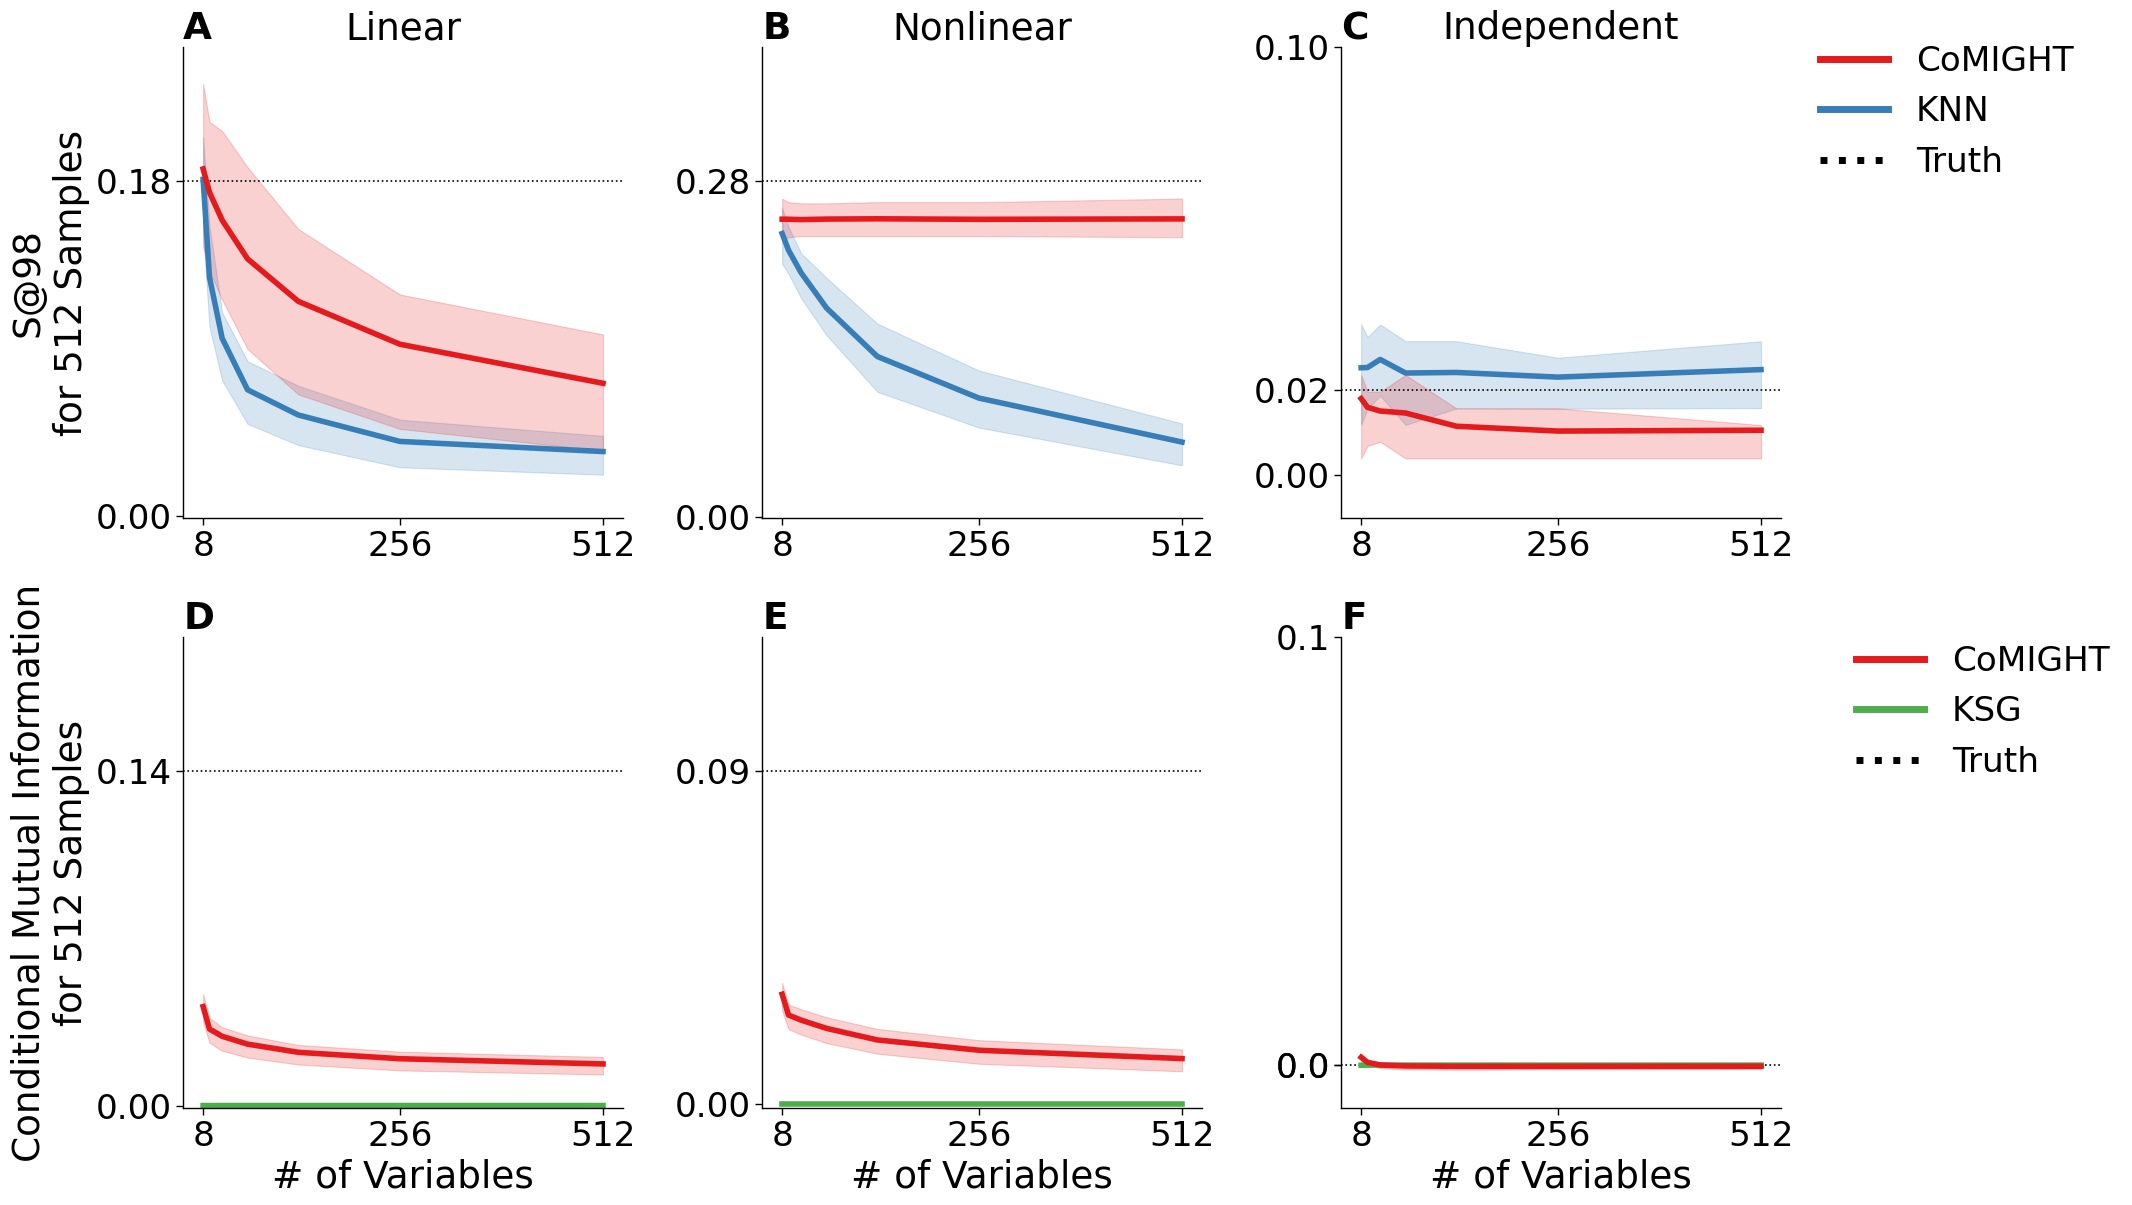

In [15]:
sns.set_context("paper", font_scale=2.8)

# in order of rows
truths = [
    {
        "mean_shiftv4": 0.18,
        "mean_shiftv3": 0.31,
        "multi_modalv2": 0.28,
        "multi_equal": 0.02,
    },
    {
        "mean_shiftv3": 0.11,
        "mean_shiftv4": 0.14,
        "multi_modalv2": 0.09,
        "multi_equal": 0.0,
    },
]

titles = ["Linear", "Nonlinear", "Independent"]

# plot the order of the dataframes per row
dfs = [
    df,
    cmi_df,
]

fig, axs = plt.subplots(2, 3, figsize=(18, 12))
for irow in range(2):
    row_df = dfs[irow]

    for idx, sim_name in enumerate(sim_names):
        plot_df = row_df[(row_df["sim_type"] == sim_name) & (row_df["n_dims_1"] < 1000)]

        plot_df["model"] = plot_df["model"].apply(lambda x: str(x).lower())
        plot_df["model"] = plot_df["model"].str.replace(
            "comight-cmi", "CoMIGHT", regex=False
        )
        plot_df["model"] = plot_df["model"].str.replace(
            "comight", "CoMIGHT", regex=False
        )
        plot_df["model"] = plot_df["model"].str.replace("knn", "KNN", regex=False)
        plot_df["model"] = plot_df["model"].str.replace("ksg", "KSG", regex=False)

        palette = {"CoMIGHT": "#e41a1c", "KNN": "#377eb8", "KSG": "#4daf4a"}

        plot_df["n_dims_1"] += 6
        # begin plotting
        ax = axs[irow][idx]

        ax.axhline([truths[irow][sim_name]], ls=":", label="Truth", color="#000000")
        hue_order = sorted([model for model in plot_df["model"].unique()])[::-1]
        ax = sns.lineplot(
            data=plot_df,
            x="n_dims_1",
            y="metric_value",
            # marker="",
            hue="model",
            hue_order=hue_order,
            ax=ax,
            palette=palette,
            linewidth=4,
            # errorbar="ci",
            errorbar=lambda x: (np.quantile(x, 0.25), np.quantile(x, 0.75)),
        )

        ax.set_xticks(
            [
                8,
                256,
                512,
                # 1024
            ]
        )
        # ax.set_xticklabels([8, 256, 512])

        # set y lim and ticks
        ax.set_ylim([-0.001, truths[irow][sim_name] + 0.4 * truths[irow][sim_name]])
        if sim_name == "multi_equal":
            ax.set_yticks([0, 0.1, truths[irow][sim_name]])
        else:
            ax.set_yticks([0, truths[irow][sim_name]])

        if sim_name == "multi_equal":
            ax.set(ylim=[-0.01, 0.1])
        sns.despine(right=True, ax=ax)
        ax.get_legend().set_visible(False)
        ax.set_ylabel(None)
        ax.set_xlabel(None)
        if irow == 0:
            ax.set_title(titles[idx])

        ax.xaxis.set_major_formatter(ScalarFormatter())
        ax.xaxis.set_minor_formatter(NullFormatter())
        ax.set_title(
            string.ascii_uppercase[irow * len(sim_names) + idx],
            loc="left",
            weight="bold",
        )

    # sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

for icol in range(len(sim_names)):
    axs[1][icol].set_xlabel("# of Variables")

axs[1][0].set_ylabel(f"Conditional Mutual Information\nfor {n_samples} Samples")
axs[0][0].set_ylabel(f"S@98\nfor {n_samples} Samples")
fig.tight_layout(pad=0.2, w_pad=1.0, h_pad=1.0)
legend_locs = [(1.08, 0.99), (1.1, 0.49)]
for i in range(2):
    leg = axs[i][0].legend(
        bbox_to_anchor=legend_locs[i],
        bbox_transform=plt.gcf().transFigure,
        ncol=1,
        loc="upper center",
        reverse=True,
    )
    leg.get_frame().set_linewidth(0.0)
    for legobj in leg.legend_handles:
        legobj.set_linewidth(5.0)

fig_name = "figure-s5"
# plt.savefig(f"{FIG_PATH}/{fig_name}.svg", transparent=True, bbox_inches="tight")
plt.show()

In [17]:
2**9

512